# Plotting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables
import beta
import getMasks

## Access Mock Parameters

Here we are declaring all the `config.yaml` file parameters as local parameters.

In [2]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook()

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

## Access Ananke Data

Here we are accessing the data with and without the satellite included. Thus, we are working with two different surveys. 

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b.h5")
ananke_sat_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b_sat.h5")
print(f"\nOpening data from: \n{ananke_file_path} \n{ananke_sat_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print(f"{ananke_file_path} file does not exist.")
    
# Check if the file exists
if os.path.exists(ananke_sat_file_path):
    # Proceed with opening the file
    survey_sat = vaex.open(ananke_sat_file_path)
else:
    print(f"{ananke_sat_file_path} file does not exist.")


Opening data from: 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b.h5 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b_sat.h5


In [4]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'calcium', 'carbon', 'dec', 'dform', 'dmod', 'feh', 'glat', 'glon', 'grav', 'helium', 'lsst_gmag', 'lsst_gmag_Err', 'lsst_gmag_Intrinsic', 'lsst_gmag_Sig', 'lsst_imag', 'lsst_imag_Err', 'lsst_imag_Intrinsic', 'lsst_imag_Sig', 'lsst_rmag', 'lsst_rmag_Err', 'lsst_rmag_Intrinsic', 'lsst_rmag_Sig', 'lsst_umag', 'lsst_umag_Err', 'lsst_umag_Intrinsic', 'lsst_umag_Sig', 'lsst_ymag', 'lsst_ymag_Err', 'lsst_ymag_Intrinsic', 'lsst_ymag_Sig', 'lsst_zmag', 'lsst_zmag_Err', 'lsst_zmag_Intrinsic', 'lsst_zmag_Sig', 'lum', 'mact', 'magnesium', 'mtip', 'mub', 'mudec', 'mul', 'mura', 'neon', 'nitrogen', 'oxygen', 'parentid', 'partid', 'pi', 'px', 'py', 'pz', 'ra', 'rad', 'silicon', 'smass', 'sulphur', 'teff', 'vr', 'vx', 'vy', 'vz']


In [5]:
# Extract apparent magnitudes
app_g_mag = survey.lsst_gmag.to_numpy()
app_r_mag = survey.lsst_rmag.to_numpy()
app_i_mag = survey.lsst_imag.to_numpy()
app_u_mag = survey.lsst_umag.to_numpy()
app_y_mag = survey.lsst_ymag.to_numpy()
app_z_mag = survey.lsst_zmag.to_numpy()

In [6]:
# Extract apparent magnitudes without satellite
app_g_mag_sat = survey_sat.lsst_gmag.to_numpy()
app_r_mag_sat = survey_sat.lsst_rmag.to_numpy()
app_i_mag_sat = survey_sat.lsst_imag.to_numpy()
app_u_mag_sat = survey_sat.lsst_umag.to_numpy()
app_y_mag_sat = survey_sat.lsst_ymag.to_numpy()
app_z_mag_sat = survey_sat.lsst_zmag.to_numpy()

In [7]:
# Extract absolute magnitudes
# NOTE: THIS VALUE IS NOT ACTUALLY ABS MAGNITUDE
g_mag = survey.lsst_gmag_Intrinsic.to_numpy()
r_mag = survey.lsst_rmag_Intrinsic.to_numpy()
i_mag = survey.lsst_imag_Intrinsic.to_numpy()
u_mag = survey.lsst_umag_Intrinsic.to_numpy()
y_mag = survey.lsst_ymag_Intrinsic.to_numpy()
z_mag = survey.lsst_zmag_Intrinsic.to_numpy()

In [8]:
# Extract absolute magnitudes without satellite
# NOTE: THIS VALUE IS NOT ACTUALLY ABS MAGNITUDE
g_mag_sat = survey_sat.lsst_gmag_Intrinsic.to_numpy()
r_mag_sat = survey_sat.lsst_rmag_Intrinsic.to_numpy()
i_mag_sat = survey_sat.lsst_imag_Intrinsic.to_numpy()
u_mag_sat = survey_sat.lsst_umag_Intrinsic.to_numpy()
y_mag_sat = survey_sat.lsst_ymag_Intrinsic.to_numpy()
z_mag_sat = survey_sat.lsst_zmag_Intrinsic.to_numpy()

In [9]:
# Extract metalicity
feh = survey.feh.to_numpy()

In [10]:
# Extract metalicity without satellite
feh_sat = survey_sat.feh.to_numpy()

## Access FIRE Data

### With Satellite

In [11]:
redshift = 0.
    
part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=sim_dir,
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12b_res7100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12b_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 58588459 particles
    star      (id = 4): 16869462 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5
    snapshot_600.4.hdf5
    snapshot_600.5.hdf5
    snapshot_600.6.hdf5
    snapshot_600.7.hdf5

* reading cosmological parameters from:  home/jovyan/data/fire2/m12b_res7100/initial_condition/ic_agora_m12b.conf

* checking sanity of particle properties
! 

### Without Satellite

In [12]:
# array of positions in principal axes (in kpc)
pos_pa = part['star'].prop('host.distance.principal')

# Blank satellite mask
satellite_mask = np.ones(len(pos_pa), dtype=bool)
    
# Store satellite indices (from Mia)
all_unique_lmc_inds = np.loadtxt(sat_id_dir)
all_inds = part['star'].prop('id')
remaining_indices = np.setdiff1d(all_inds, np.array(all_unique_lmc_inds))
id_indices = np.where(np.isin(all_inds, remaining_indices))[0]
only_lmc_indices = np.where(~np.isin(all_inds, remaining_indices))[0]
    
# Remove satellite
satellite_mask[only_lmc_indices] = False

## Extract Parameters

In [13]:
# Define the bin edges
bins = 200

In [14]:
# Create a binned radius array 
dr = np.linspace(0, rmax, bins)

### 1. Data before ananke (FIRE)

### With Satellite

In [15]:
firePos = part['star'].prop('host.distance') # star position in kpc
fireMass = part['star']['mass']              # star mass in Msun
fireVel = part['star'].prop('host.velocity') # star velocity in km/s

In [16]:
# Compute radial distance
fireRadial = np.sqrt((firePos[:,0])**2 + (firePos[:,1])**2 + (firePos[:,2])**2)

# Compute the FIRE density profile
fireCounts, fireEdges = np.histogram(fireRadial, bins=bins, range=(rmin, rmax))
fireVolume = 4.0/3.0 * np.pi * (np.power(fireEdges[1:], 3) - np.power(fireEdges[:-1], 3))
fireDensity = fireCounts / fireVolume

In [17]:
# Call the velocity dispersion function from beta.py
fire_vr_disp_r, fire_vtheta_disp_r, fire_vphi_disp_r = beta.velocity_dispersions_r(firePos, fireVel, bins, rmax)

# Calculate radial velocity dispersion 
fire_v_disp = (fire_vtheta_disp_r**2 + fire_vphi_disp_r**2)**0.5

### Without Satellite

In [18]:
firePosSat = firePos[satellite_mask]
fireMassSat = fireMass[satellite_mask]
fireVelSat = fireVel[satellite_mask]

In [19]:
# Compute radial distance
fireRadialSat = np.sqrt((firePosSat[:,0])**2 + (firePosSat[:,1])**2 + (firePosSat[:,2])**2)

# Compute the FIRE density profile
fireCountsSat, fireEdgesSat = np.histogram(fireRadialSat, bins=bins, range=(rmin, rmax))
fireVolumeSat = 4.0/3.0 * np.pi * (np.power(fireEdgesSat[1:], 3) - np.power(fireEdgesSat[:-1], 3))
fireDensitySat = fireCountsSat / fireVolumeSat

In [20]:
# Call the velocity dispersion function from beta.py
fire_vr_disp_r_sat, fire_vtheta_disp_r_sat, fire_vphi_disp_r_sat = beta.velocity_dispersions_r(firePosSat, fireVelSat, bins, rmax)

# Calculate radial velocity dispersion 
fire_v_disp_sat = (fire_vtheta_disp_r_sat**2 + fire_vphi_disp_r_sat**2)**0.5

### 2. Data after ananke

### With Satellite

In [21]:
# Extract parameters
anankeRadial = survey.rad.to_numpy()
anankeMass = survey.smass.to_numpy()            

In [22]:
# Compute the ananke density profile
anankeCounts, anankeEdges = np.histogram(anankeRadial, bins=bins, range=(rmin, rmax))
anankeVolume = 4.0/3.0 * np.pi * (np.power(anankeEdges[1:], 3) - np.power(anankeEdges[:-1], 3))
anankeDensity = anankeCounts / anankeVolume

In [23]:
# Extract pos and vel
anankePos = np.stack((survey.px.to_numpy(), survey.py.to_numpy(), survey.pz.to_numpy())).T
anankeVel = np.stack((survey.vx.to_numpy(), survey.vy.to_numpy(), survey.vz.to_numpy())).T

In [24]:
# Call the velocity dispersion function from beta.py
ananke_vr_disp_r, ananke_vtheta_disp_r, ananke_vphi_disp_r = beta.velocity_dispersions_r(anankePos, anankeVel, bins, rmax)

# Calculate radial velocity dispersion 
ananke_v_disp = (ananke_vtheta_disp_r**2 + ananke_vphi_disp_r**2)**0.5

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Without Satellite

In [25]:
# Extract parameters
anankeRadialSat = survey_sat.rad.to_numpy()
anankeMassSat = survey_sat.smass.to_numpy()                   

In [26]:
# Compute the ananke density profile
anankeCountsSat, anankeEdgesSat = np.histogram(anankeRadialSat, bins=bins, range=(rmin, rmax))
anankeVolumeSat = 4.0/3.0 * np.pi * (np.power(anankeEdgesSat[1:], 3) - np.power(anankeEdgesSat[:-1], 3))
anankeDensitySat = anankeCountsSat / anankeVolumeSat

In [27]:
# Extract pos and vel
anankePosSat = np.stack((survey_sat.px.to_numpy(), survey_sat.py.to_numpy(), survey_sat.pz.to_numpy())).T
anankeVelSat = np.stack((survey_sat.vx.to_numpy(), survey_sat.vy.to_numpy(), survey_sat.vz.to_numpy())).T

In [28]:
# Call the velocity dispersion function from beta.py
ananke_vr_disp_r_sat, ananke_vtheta_disp_r_sat, ananke_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat, anankeVelSat, bins, rmax)

# Calculate radial velocity dispersion 
ananke_v_disp_sat = (ananke_vtheta_disp_r_sat**2 + ananke_vphi_disp_r_sat**2)**0.5

### 3. BHB

### With Satellite

In [29]:
# Calculate u - g
u_minus_g = app_u_mag - app_g_mag

In [30]:
# Calculate g - r
g_minus_r = app_g_mag - app_r_mag

In [31]:
# Get BHB mask
bhb_mask = getMasks.getBHB(g_minus_r, u_minus_g, g_mag)

In [32]:
# Compute the BHB density profile
bhbCounts, bhbEdges = np.histogram(anankeRadial[bhb_mask], bins=bins, range=(rmin, rmax))
bhbVolume = 4.0/3.0 * np.pi * (np.power(bhbEdges[1:], 3) - np.power(bhbEdges[:-1], 3))
bhbDensity = bhbCounts / bhbVolume

In [33]:
# Call the velocity dispersion function from beta.py
bhb_vr_disp_r, bhb_vtheta_disp_r, bhb_vphi_disp_r = beta.velocity_dispersions_r(anankePos[bhb_mask], anankeVel[bhb_mask], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp = (bhb_vtheta_disp_r**2 + bhb_vphi_disp_r**2)**0.5

### Without Satellite

In [34]:
# Calculate u - g
u_minus_g_sat = app_u_mag_sat - app_g_mag_sat

In [35]:
# Calculate g - r
g_minus_r_sat = app_g_mag_sat - app_r_mag_sat

In [36]:
# Get BHB mask
bhb_mask_sat = getMasks.getBHB(g_minus_r_sat, u_minus_g_sat, g_mag_sat)

In [37]:
# Compute the BHB density profile
bhbCountsSat, bhbEdgesSat = np.histogram(anankeRadialSat[bhb_mask_sat], bins=bins, range=(rmin, rmax))
bhbVolumeSat = 4.0/3.0 * np.pi * (np.power(bhbEdgesSat[1:], 3) - np.power(bhbEdgesSat[:-1], 3))
bhbDensitySat = bhbCountsSat / bhbVolumeSat

In [38]:
# Call the velocity dispersion function from beta.py
bhb_vr_disp_r_sat, bhb_vtheta_disp_r_sat, bhb_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[bhb_mask_sat], anankeVelSat[bhb_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
bhb_v_disp_sat = (bhb_vtheta_disp_r_sat**2 + bhb_vphi_disp_r_sat**2)**0.5

### 4. K Giant

In order to isolate K giants in our stellar halo models we have used the colour cuts $0.5 < g − r < 1.3$ and $0.5 <
u−g < 3.5$ from Xue et al. (2014), along with their proposed empirical polynomial relation between (g −r) and [Fe/H] to remove red horizontal branch and red-clump (RC) giants. All stars with $(g − r) > 0.087 [Fe/H]2 + 0.39 [Fe/H] + 0.96$ is excluded from the selection. An additional cut of $M_g < 4$ removes faint dwarf stars of the same colours

### With Satellite

In [39]:
# Get K-Giant mask
kgiant_mask = getMasks.getKGiant(g_minus_r, u_minus_g, g_mag, feh)

In [40]:
# Compute the K Giant density profile
kgiantCounts, kgiantEdges = np.histogram(anankeRadial[kgiant_mask], bins=bins, range=(rmin, rmax))
kgiantVolume = 4.0/3.0 * np.pi * (np.power(kgiantEdges[1:], 3) - np.power(kgiantEdges[:-1], 3))
kgiantDensity = kgiantCounts / kgiantVolume

In [41]:
# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r, kgiant_vtheta_disp_r, kgiant_vphi_disp_r = beta.velocity_dispersions_r(anankePos[kgiant_mask], anankeVel[kgiant_mask], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp = (kgiant_vtheta_disp_r**2 + kgiant_vphi_disp_r**2)**0.5

### Without Satellite

In [42]:
# Get K-Giant mask without satellite
kgiant_mask_sat = getMasks.getKGiant(g_minus_r_sat, u_minus_g_sat, g_mag_sat, feh_sat)

In [43]:
# Compute the K Giant density profile
kgiantCountsSat, kgiantEdgesSat = np.histogram(anankeRadialSat[kgiant_mask_sat], bins=bins, range=(rmin, rmax))
kgiantVolumeSat = 4.0/3.0 * np.pi * (np.power(kgiantEdgesSat[1:], 3) - np.power(kgiantEdgesSat[:-1], 3))
kgiantDensitySat = kgiantCountsSat / kgiantVolumeSat

In [44]:
# Call the velocity dispersion function from beta.py
kgiant_vr_disp_r_sat, kgiant_vtheta_disp_r_sat, kgiant_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[kgiant_mask_sat], anankeVelSat[kgiant_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
kgiant_v_disp_sat = (kgiant_vtheta_disp_r_sat**2 + kgiant_vphi_disp_r_sat**2)**0.5

### 5. MSTO

### With Satellite

In [45]:
# Create MSTO mask
msto_mask = getMasks.getMSTO(g_minus_r, g_mag)

In [46]:
# Compute the MSTO density profile
mstoCounts, mstoEdges = np.histogram(anankeRadial[msto_mask], bins=bins, range=(rmin, rmax))
mstoVolume = 4.0/3.0 * np.pi * (np.power(mstoEdges[1:], 3) - np.power(mstoEdges[:-1], 3))
mstoDensity = mstoCounts / mstoVolume

In [47]:
# Call the velocity dispersion function from beta.py
msto_vr_disp_r, msto_vtheta_disp_r, msto_vphi_disp_r = beta.velocity_dispersions_r(anankePos[msto_mask], anankeVel[msto_mask], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp = (msto_vtheta_disp_r**2 + msto_vphi_disp_r**2)**0.5

### Without Satellite

In [48]:
# Create MSTO mask without satellite
msto_mask_sat = getMasks.getMSTO(g_minus_r_sat, g_mag_sat)

In [49]:
# Compute the MSTO density profile
mstoCountsSat, mstoEdgesSat = np.histogram(anankeRadialSat[msto_mask_sat], bins=bins, range=(rmin, rmax))
mstoVolumeSat = 4.0/3.0 * np.pi * (np.power(mstoEdgesSat[1:], 3) - np.power(mstoEdgesSat[:-1], 3))
mstoDensitySat = mstoCountsSat / mstoVolumeSat

In [50]:
# Call the velocity dispersion function from beta.py
msto_vr_disp_r_sat, msto_vtheta_disp_r_sat, msto_vphi_disp_r_sat = beta.velocity_dispersions_r(anankePosSat[msto_mask_sat], anankeVelSat[msto_mask_sat], bins, rmax)

# Calculate radial velocity dispersion 
msto_v_disp_sat = (msto_vtheta_disp_r_sat**2 + msto_vphi_disp_r_sat**2)**0.5

## Individual Plots

### Density Profile With Satellite

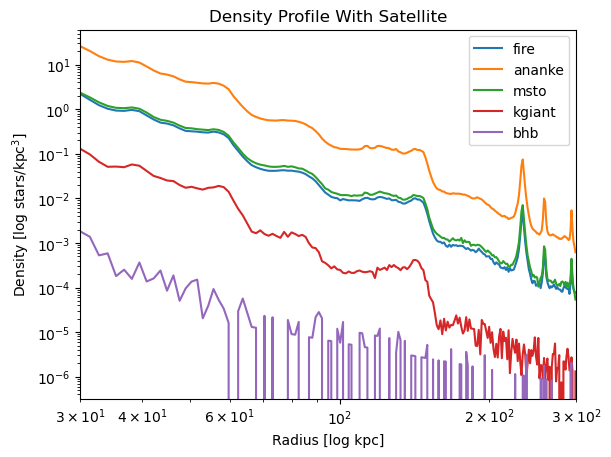

In [150]:
# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(fireEdges[:-1], fireDensity, label='fire')
ax.loglog(anankeEdges[:-1], anankeDensity, label='ananke')
ax.loglog(mstoEdges[:-1], mstoDensity, label='msto')
ax.loglog(kgiantEdges[:-1], kgiantDensity, label='kgiant')
ax.loglog(bhbEdges[:-1], bhbDensity, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Density Profile With Satellite')
plt.show()

In [151]:
from scipy.interpolate import CubicSpline

# Define interpolation function
def interpolate_density(x, y):
    # Remove zero values before interpolation
    nonzero_indices = y > 0
    x_nonzero = x[nonzero_indices]
    y_nonzero = y[nonzero_indices]
    
    # Perform cubic spline interpolation (log scale for smoother curve)
    cs = CubicSpline(np.log(x_nonzero), np.log(y_nonzero))
    
    # Interpolate values for all x
    x_interp = np.exp(np.log(x)) 
    y_interp = np.exp(cs(np.log(x_interp))) 
    
    return x_interp, y_interp

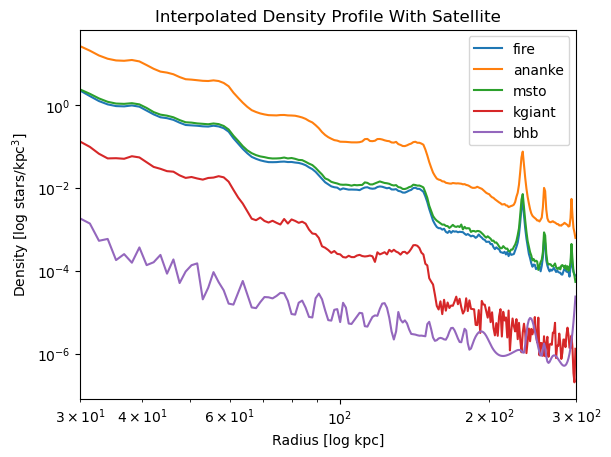

In [152]:
# Apply interpolation to each dataset
fire_x_interp, fire_y_interp = interpolate_density(fireEdges[:-1], fireDensity)
ananke_x_interp, ananke_y_interp = interpolate_density(anankeEdges[:-1], anankeDensity)
msto_x_interp, msto_y_interp = interpolate_density(mstoEdges[:-1], mstoDensity)
kgiant_x_interp, kgiant_y_interp = interpolate_density(kgiantEdges[:-1], kgiantDensity)
bhb_x_interp, bhb_y_interp = interpolate_density(bhbEdges[:-1], bhbDensity)

# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fire_x_interp, fire_y_interp, label='fire')
ax.loglog(ananke_x_interp, ananke_y_interp, label='ananke')
ax.loglog(msto_x_interp, msto_y_interp, label='msto')
ax.loglog(kgiant_x_interp, kgiant_y_interp, label='kgiant')
ax.loglog(bhb_x_interp, bhb_y_interp, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Interpolated Density Profile With Satellite')
plt.show()

### Radial Velocity Dispersion With Satellite

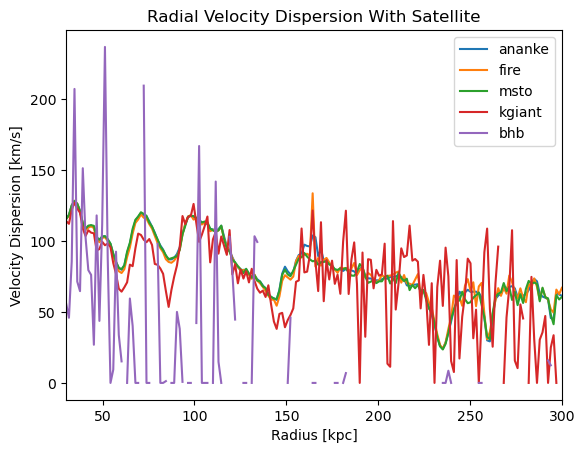

In [153]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_vr_disp_r, label='ananke')
ax.plot(dr[1:], fire_vr_disp_r, label='fire')
ax.plot(dr[1:], msto_vr_disp_r, label='msto')
ax.plot(dr[1:], kgiant_vr_disp_r, label='kgiant')
ax.plot(dr[1:], bhb_vr_disp_r, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Radial Velocity Dispersion With Satellite')
plt.show()

In [154]:
from scipy.interpolate import CubicSpline

# Define interpolation function
def interpolate_velocity(x, y):
    # Remove non-finite values before interpolation
    finite_indices = np.isfinite(y)
    x_finite = x[finite_indices]
    y_finite = y[finite_indices]
    
    # Perform cubic spline interpolation
    cs = CubicSpline(x_finite, y_finite)
    
    # Interpolate values for all x
    x_interp = x
    y_interp = cs(x_interp)
    
    return x_interp, y_interp

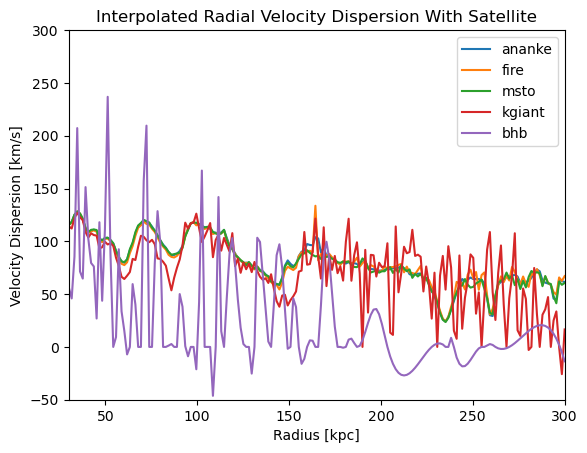

In [155]:
# Apply interpolation to each dataset for velocity dispersion
ananke_r_interp, ananke_vr_disp_interp = interpolate_velocity(dr[1:], ananke_vr_disp_r)
fire_r_interp, fire_vr_disp_interp = interpolate_velocity(dr[1:], fire_vr_disp_r)
msto_r_interp, msto_vr_disp_interp = interpolate_velocity(dr[1:], msto_vr_disp_r)
kgiant_r_interp, kgiant_vr_disp_interp = interpolate_velocity(dr[1:], kgiant_vr_disp_r)
bhb_r_interp, bhb_vr_disp_interp = interpolate_velocity(dr[1:], bhb_vr_disp_r)

# Plot the velocity dispersion data with interpolated values
fig, ax = plt.subplots()
ax.plot(ananke_r_interp, ananke_vr_disp_interp, label='ananke')
ax.plot(fire_r_interp, fire_vr_disp_interp, label='fire')
ax.plot(msto_r_interp, msto_vr_disp_interp, label='msto')
ax.plot(kgiant_r_interp, kgiant_vr_disp_interp, label='kgiant')
ax.plot(bhb_r_interp, bhb_vr_disp_interp, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
ax.set_ylim(-50, 300)
plt.legend()
plt.title('Interpolated Radial Velocity Dispersion With Satellite')
plt.show()

### Tangential Velocity Dispersion With Satellite

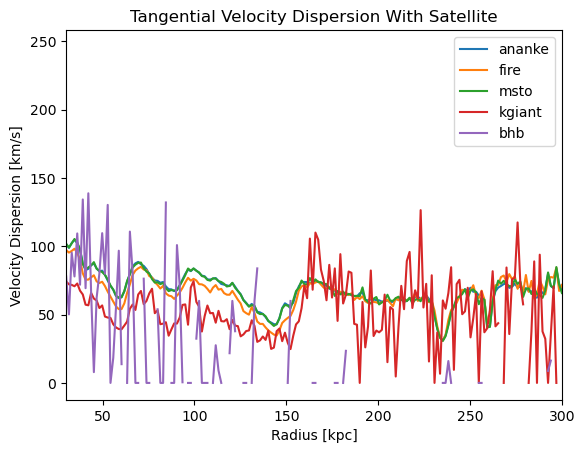

In [156]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_v_disp, label='ananke')
ax.plot(dr[1:], fire_v_disp, label='fire')
ax.plot(dr[1:], msto_v_disp, label='msto')
ax.plot(dr[1:], kgiant_v_disp, label='kgiant')
ax.plot(dr[1:], bhb_v_disp, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Tangential Velocity Dispersion With Satellite')
plt.show()

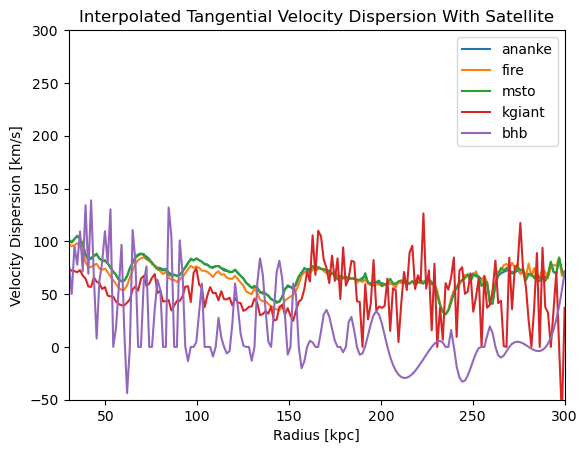

In [157]:
# Apply interpolation to each dataset for velocity dispersion
ananke_r_interp, ananke_v_disp_interp = interpolate_velocity(dr[1:], ananke_v_disp)
fire_r_interp, fire_v_disp_interp = interpolate_velocity(dr[1:], fire_v_disp)
msto_r_interp, msto_v_disp_interp = interpolate_velocity(dr[1:], msto_v_disp)
kgiant_r_interp, kgiant_v_disp_interp = interpolate_velocity(dr[1:], kgiant_v_disp)
bhb_r_interp, bhb_v_disp_interp = interpolate_velocity(dr[1:], bhb_v_disp)

# Plot the velocity dispersion data with interpolated values
fig, ax = plt.subplots()
ax.plot(ananke_r_interp, ananke_v_disp_interp, label='ananke')
ax.plot(fire_r_interp, fire_v_disp_interp, label='fire')
ax.plot(msto_r_interp, msto_v_disp_interp, label='msto')
ax.plot(kgiant_r_interp, kgiant_v_disp_interp, label='kgiant')
ax.plot(bhb_r_interp, bhb_v_disp_interp, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
ax.set_ylim(-50, 300)
plt.legend()
plt.title('Interpolated Tangential Velocity Dispersion With Satellite')
plt.show()

### Density Profile Without Satellite

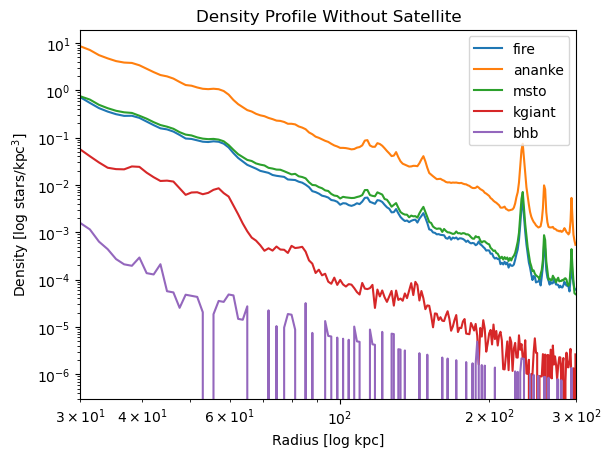

In [158]:
# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], fireDensitySat, label='fire')
ax.loglog(anankeEdgesSat[:-1], anankeDensitySat, label='ananke')
ax.loglog(mstoEdgesSat[:-1], mstoDensitySat, label='msto')
ax.loglog(kgiantEdgesSat[:-1], kgiantDensitySat, label='kgiant')
ax.loglog(bhbEdgesSat[:-1], bhbDensitySat, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Density Profile Without Satellite')
plt.show()

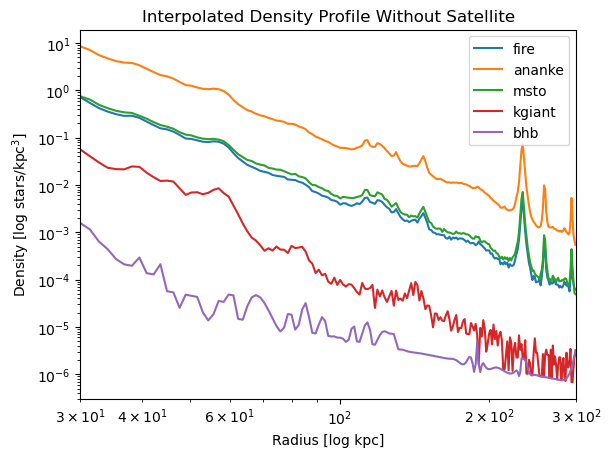

In [159]:
# Apply interpolation to each dataset
fire_x_interp_sat, fire_y_interp_sat = interpolate_density(fireEdgesSat[:-1], fireDensitySat)
ananke_x_interp_sat, ananke_y_interp_sat = interpolate_density(anankeEdgesSat[:-1], anankeDensitySat)
msto_x_interp_sat, msto_y_interp_sat = interpolate_density(mstoEdgesSat[:-1], mstoDensitySat)
kgiant_x_interp_sat, kgiant_y_interp_sat = interpolate_density(kgiantEdgesSat[:-1], kgiantDensitySat)
bhb_x_interp_sat, bhb_y_interp_sat = interpolate_density(bhbEdgesSat[:-1], bhbDensitySat)

# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fire_x_interp_sat, fire_y_interp_sat, label='fire')
ax.loglog(ananke_x_interp_sat, ananke_y_interp_sat, label='ananke')
ax.loglog(msto_x_interp_sat, msto_y_interp_sat, label='msto')
ax.loglog(kgiant_x_interp_sat, kgiant_y_interp_sat, label='kgiant')
ax.loglog(bhb_x_interp_sat, bhb_y_interp_sat, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Interpolated Density Profile Without Satellite')
plt.show()

### Radial Velocity Dispersion Without Satellite

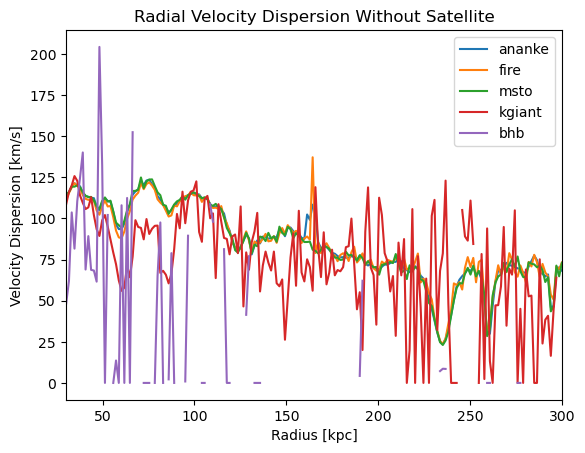

In [160]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_vr_disp_r_sat, label='ananke')
ax.plot(dr[1:], fire_vr_disp_r_sat, label='fire')
ax.plot(dr[1:], msto_vr_disp_r_sat, label='msto')
ax.plot(dr[1:], kgiant_vr_disp_r_sat, label='kgiant')
ax.plot(dr[1:], bhb_vr_disp_r_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Radial Velocity Dispersion Without Satellite')
plt.show()

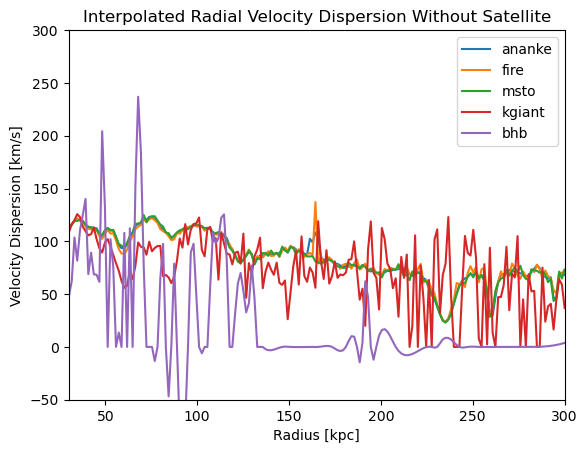

In [161]:
# Apply interpolation to each dataset for velocity dispersion
ananke_r_interp_sat, ananke_vr_disp_interp_sat = interpolate_velocity(dr[1:], ananke_vr_disp_r_sat)
fire_r_interp_sat, fire_vr_disp_interp_sat = interpolate_velocity(dr[1:], fire_vr_disp_r_sat)
msto_r_interp_sat, msto_vr_disp_interp_sat = interpolate_velocity(dr[1:], msto_vr_disp_r_sat)
kgiant_r_interp_sat, kgiant_vr_disp_interp_sat = interpolate_velocity(dr[1:], kgiant_vr_disp_r_sat)
bhb_r_interp_sat, bhb_vr_disp_interp_sat = interpolate_velocity(dr[1:], bhb_vr_disp_r_sat)

# Plot the velocity dispersion data with interpolated values
fig, ax = plt.subplots()
ax.plot(ananke_r_interp_sat, ananke_vr_disp_interp_sat, label='ananke')
ax.plot(fire_r_interp_sat, fire_vr_disp_interp_sat, label='fire')
ax.plot(msto_r_interp_sat, msto_vr_disp_interp_sat, label='msto')
ax.plot(kgiant_r_interp_sat, kgiant_vr_disp_interp_sat, label='kgiant')
ax.plot(bhb_r_interp_sat, bhb_vr_disp_interp_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
ax.set_ylim(-50, 300)
plt.legend()
plt.title('Interpolated Radial Velocity Dispersion Without Satellite')
plt.show()

### Tangential Velocity Dispersion Without Satellite

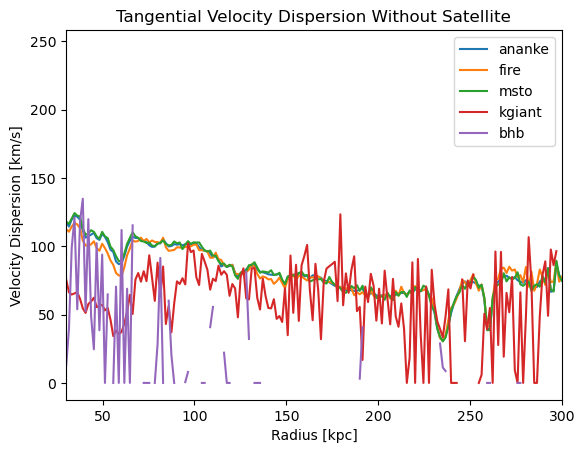

In [162]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(dr[1:], ananke_v_disp_sat, label='ananke')
ax.plot(dr[1:], fire_v_disp_sat, label='fire')
ax.plot(dr[1:], msto_v_disp_sat, label='msto')
ax.plot(dr[1:], kgiant_v_disp_sat, label='kgiant')
ax.plot(dr[1:], bhb_v_disp_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
plt.legend()
plt.title('Tangential Velocity Dispersion Without Satellite')
plt.show()

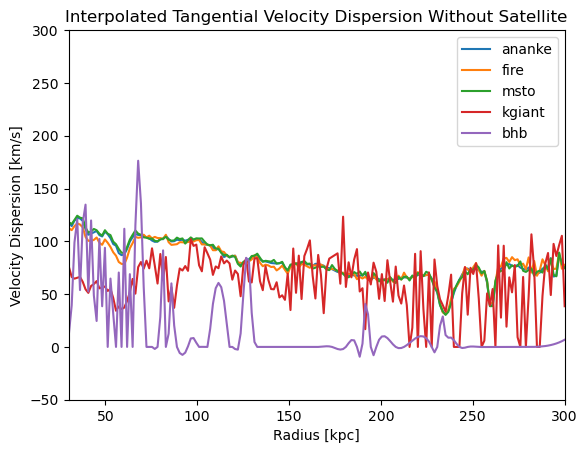

In [163]:
# Apply interpolation to each dataset for velocity dispersion
ananke_r_interp_sat, ananke_v_disp_interp_sat = interpolate_velocity(dr[1:], ananke_v_disp_sat)
fire_r_interp_sat, fire_v_disp_interp_sat = interpolate_velocity(dr[1:], fire_v_disp_sat)
msto_r_interp_sat, msto_v_disp_interp_sat = interpolate_velocity(dr[1:], msto_v_disp_sat)
kgiant_r_interp_sat, kgiant_v_disp_interp_sat = interpolate_velocity(dr[1:], kgiant_v_disp_sat)
bhb_r_interp_sat, bhb_v_disp_interp_sat = interpolate_velocity(dr[1:], bhb_v_disp_sat)

# Plot the velocity dispersion data with interpolated values
fig, ax = plt.subplots()
ax.plot(ananke_r_interp_sat, ananke_v_disp_interp_sat, label='ananke')
ax.plot(fire_r_interp_sat, fire_v_disp_interp_sat, label='fire')
ax.plot(msto_r_interp_sat, msto_v_disp_interp_sat, label='msto')
ax.plot(kgiant_r_interp_sat, kgiant_v_disp_interp_sat, label='kgiant')
ax.plot(bhb_r_interp_sat, bhb_v_disp_interp_sat, label='bhb')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity Dispersion [km/s]')
ax.set_xlim(rmin, rmax)
ax.set_ylim(-50, 300)
plt.legend()
plt.title('Interpolated Tangential Velocity Dispersion Without Satellite')
plt.show()

## Combined Plot

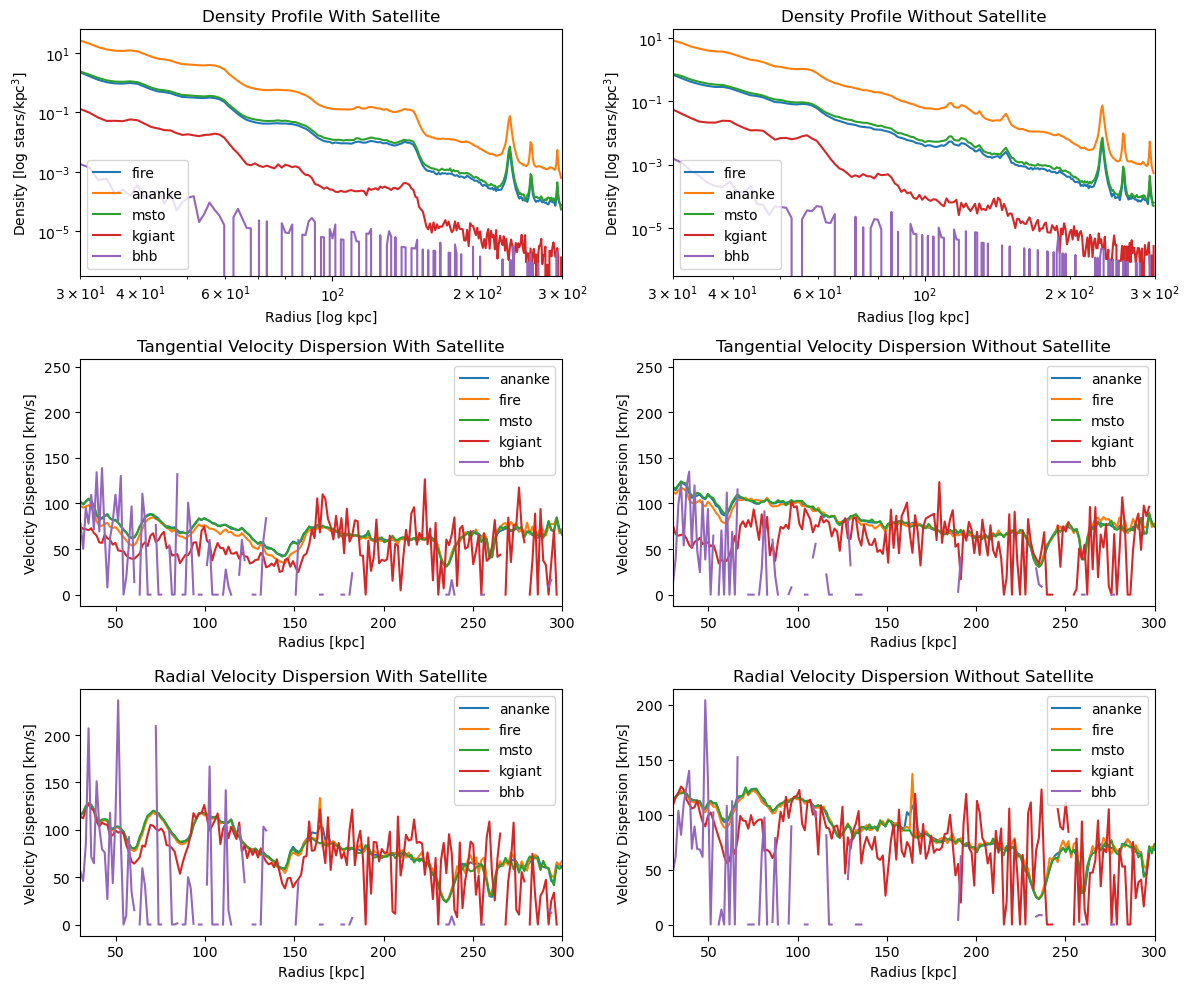

In [167]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 2 rows, 2 columns

axes[0, 0].loglog(fireEdges[:-1], fireDensity, label='fire')
axes[0, 0].loglog(anankeEdges[:-1], anankeDensity, label='ananke')
axes[0, 0].loglog(mstoEdges[:-1], mstoDensity, label='msto')
axes[0, 0].loglog(kgiantEdges[:-1], kgiantDensity, label='kgiant')
axes[0, 0].loglog(bhbEdges[:-1], bhbDensity, label='bhb')
axes[0, 0].set_xlabel('Radius [log kpc]')
axes[0, 0].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 0].set_xlim(rmin, rmax)
axes[0, 0].set_ylim()
axes[0, 0].legend()
axes[0, 0].set_title('Density Profile With Satellite')

axes[0, 1].loglog(fireEdgesSat[:-1], fireDensitySat, label='fire')
axes[0, 1].loglog(anankeEdgesSat[:-1], anankeDensitySat, label='ananke')
axes[0, 1].loglog(mstoEdgesSat[:-1], mstoDensitySat, label='msto')
axes[0, 1].loglog(kgiantEdgesSat[:-1], kgiantDensitySat, label='kgiant')
axes[0, 1].loglog(bhbEdgesSat[:-1], bhbDensitySat, label='bhb')
axes[0, 1].set_xlabel('Radius [log kpc]')
axes[0, 1].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 1].set_xlim(rmin, rmax)
axes[0, 1].set_ylim()
axes[0, 1].legend()
axes[0, 1].set_title('Density Profile Without Satellite')

axes[1, 0].plot(dr[1:], ananke_v_disp, label='ananke')
axes[1, 0].plot(dr[1:], fire_v_disp, label='fire')
axes[1, 0].plot(dr[1:], msto_v_disp, label='msto')
axes[1, 0].plot(dr[1:], kgiant_v_disp, label='kgiant')
axes[1, 0].plot(dr[1:], bhb_v_disp, label='bhb')
axes[1, 0].set_xlabel('Radius [kpc]')
axes[1, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 0].set_xlim(rmin, rmax)
axes[1, 0].legend()
axes[1, 0].set_title('Tangential Velocity Dispersion With Satellite')

axes[1, 1].plot(dr[1:], ananke_v_disp_sat, label='ananke')
axes[1, 1].plot(dr[1:], fire_v_disp_sat, label='fire')
axes[1, 1].plot(dr[1:], msto_v_disp_sat, label='msto')
axes[1, 1].plot(dr[1:], kgiant_v_disp_sat, label='kgiant')
axes[1, 1].plot(dr[1:], bhb_v_disp_sat, label='bhb')
axes[1, 1].set_xlabel('Radius [kpc]')
axes[1, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 1].set_xlim(rmin, rmax)
axes[1, 1].legend()
axes[1, 1].set_title('Tangential Velocity Dispersion Without Satellite')

axes[2, 0].plot(dr[1:], ananke_vr_disp_r, label='ananke')
axes[2, 0].plot(dr[1:], fire_vr_disp_r, label='fire')
axes[2, 0].plot(dr[1:], msto_vr_disp_r, label='msto')
axes[2, 0].plot(dr[1:], kgiant_vr_disp_r, label='kgiant')
axes[2, 0].plot(dr[1:], bhb_vr_disp_r, label='bhb')
axes[2, 0].set_xlabel('Radius [kpc]')
axes[2, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 0].set_xlim(rmin, rmax)
axes[2, 0].legend()
axes[2, 0].set_title('Radial Velocity Dispersion With Satellite')

axes[2, 1].plot(dr[1:], ananke_vr_disp_r_sat, label='ananke')
axes[2, 1].plot(dr[1:], fire_vr_disp_r_sat, label='fire')
axes[2, 1].plot(dr[1:], msto_vr_disp_r_sat, label='msto')
axes[2, 1].plot(dr[1:], kgiant_vr_disp_r_sat, label='kgiant')
axes[2, 1].plot(dr[1:], bhb_vr_disp_r_sat, label='bhb')
axes[2, 1].set_xlabel('Radius [kpc]')
axes[2, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 1].set_xlim(rmin, rmax)
axes[2, 1].legend()
axes[2, 1].set_title('Radial Velocity Dispersion Without Satellite')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

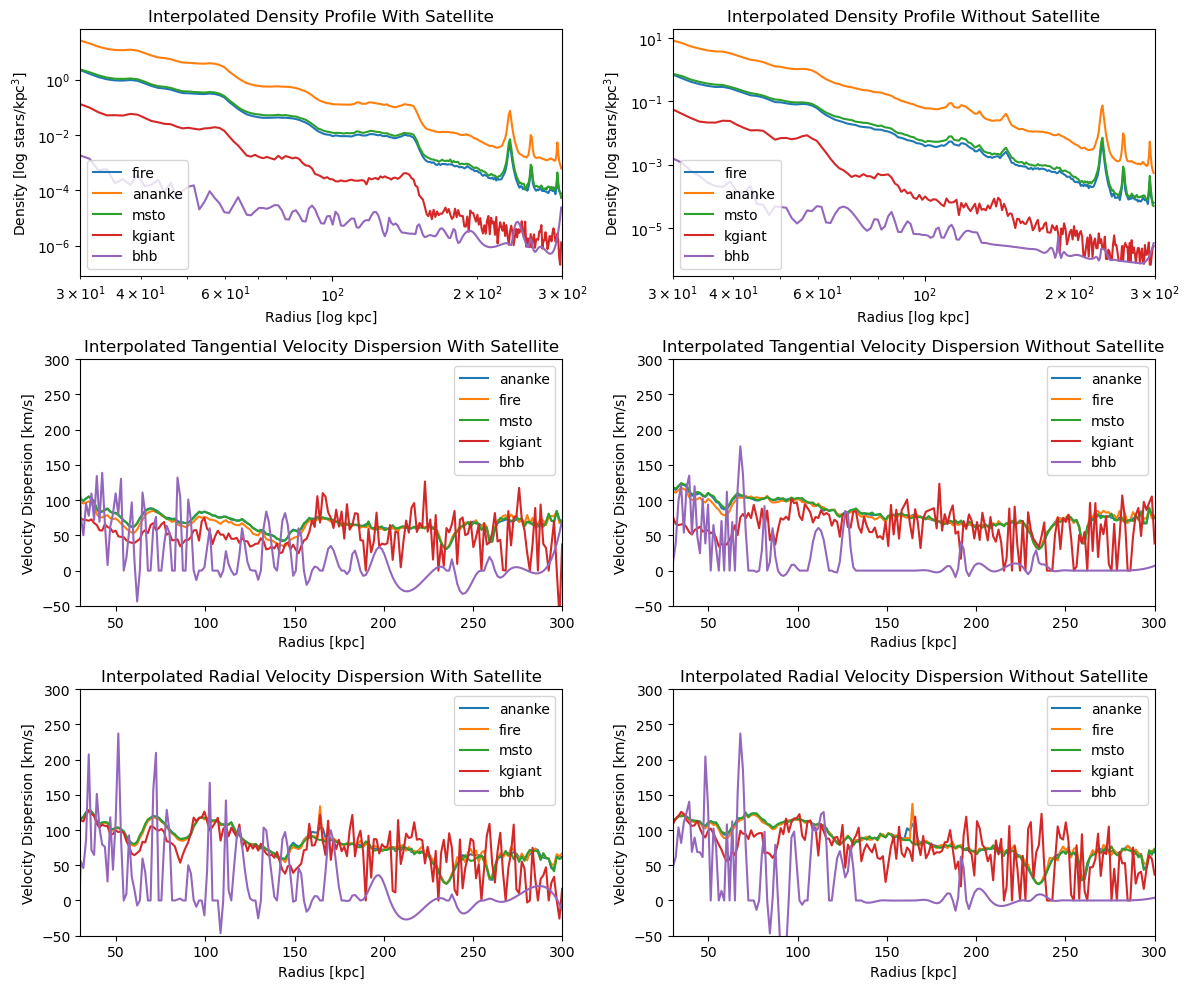

In [168]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 2 rows, 2 columns

axes[0, 0].loglog(fire_x_interp, fire_y_interp, label='fire')
axes[0, 0].loglog(ananke_x_interp, ananke_y_interp, label='ananke')
axes[0, 0].loglog(msto_x_interp, msto_y_interp, label='msto')
axes[0, 0].loglog(kgiant_x_interp, kgiant_y_interp, label='kgiant')
axes[0, 0].loglog(bhb_x_interp, bhb_y_interp, label='bhb')
axes[0, 0].set_xlabel('Radius [log kpc]')
axes[0, 0].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 0].set_xlim(rmin, rmax)
axes[0, 0].set_ylim()
axes[0, 0].legend()
axes[0, 0].set_title('Interpolated Density Profile With Satellite')

axes[0, 1].loglog(fire_x_interp_sat, fire_y_interp_sat, label='fire')
axes[0, 1].loglog(ananke_x_interp_sat, ananke_y_interp_sat, label='ananke')
axes[0, 1].loglog(msto_x_interp_sat, msto_y_interp_sat, label='msto')
axes[0, 1].loglog(kgiant_x_interp_sat, kgiant_y_interp_sat, label='kgiant')
axes[0, 1].loglog(bhb_x_interp_sat, bhb_y_interp_sat, label='bhb')
axes[0, 1].set_xlabel('Radius [log kpc]')
axes[0, 1].set_ylabel('Density [log stars/kpc$^3$]')
axes[0, 1].set_xlim(rmin, rmax)
axes[0, 1].set_ylim()
axes[0, 1].legend()
axes[0, 1].set_title('Interpolated Density Profile Without Satellite')

axes[1, 0].plot(ananke_r_interp, ananke_v_disp_interp, label='ananke')
axes[1, 0].plot(fire_r_interp, fire_v_disp_interp, label='fire')
axes[1, 0].plot(msto_r_interp, msto_v_disp_interp, label='msto')
axes[1, 0].plot(kgiant_r_interp, kgiant_v_disp_interp, label='kgiant')
axes[1, 0].plot(bhb_r_interp, bhb_v_disp_interp, label='bhb')
axes[1, 0].set_xlabel('Radius [kpc]')
axes[1, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 0].set_xlim(rmin, rmax)
axes[1, 0].set_ylim(-50, 300)
axes[1, 0].legend()
axes[1, 0].set_title('Interpolated Tangential Velocity Dispersion With Satellite')

axes[1, 1].plot(ananke_r_interp_sat, ananke_v_disp_interp_sat, label='ananke')
axes[1, 1].plot(fire_r_interp_sat, fire_v_disp_interp_sat, label='fire')
axes[1, 1].plot(msto_r_interp_sat, msto_v_disp_interp_sat, label='msto')
axes[1, 1].plot(kgiant_r_interp_sat, kgiant_v_disp_interp_sat, label='kgiant')
axes[1, 1].plot(bhb_r_interp_sat, bhb_v_disp_interp_sat, label='bhb')
axes[1, 1].set_xlabel('Radius [kpc]')
axes[1, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[1, 1].set_xlim(rmin, rmax)
axes[1, 1].set_ylim(-50, 300)
axes[1, 1].legend()
axes[1, 1].set_title('Interpolated Tangential Velocity Dispersion Without Satellite')

axes[2, 0].plot(ananke_r_interp, ananke_vr_disp_interp, label='ananke')
axes[2, 0].plot(fire_r_interp, fire_vr_disp_interp, label='fire')
axes[2, 0].plot(msto_r_interp, msto_vr_disp_interp, label='msto')
axes[2, 0].plot(kgiant_r_interp, kgiant_vr_disp_interp, label='kgiant')
axes[2, 0].plot(bhb_r_interp, bhb_vr_disp_interp, label='bhb')
axes[2, 0].set_xlabel('Radius [kpc]')
axes[2, 0].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 0].set_xlim(rmin, rmax)
axes[2, 0].set_ylim(-50, 300)
axes[2, 0].legend()
axes[2, 0].set_title('Interpolated Radial Velocity Dispersion With Satellite')

axes[2, 1].plot(ananke_r_interp_sat, ananke_vr_disp_interp_sat, label='ananke')
axes[2, 1].plot(fire_r_interp_sat, fire_vr_disp_interp_sat, label='fire')
axes[2, 1].plot(msto_r_interp_sat, msto_vr_disp_interp_sat, label='msto')
axes[2, 1].plot(kgiant_r_interp_sat, kgiant_vr_disp_interp_sat, label='kgiant')
axes[2, 1].plot(bhb_r_interp_sat, bhb_vr_disp_interp_sat, label='bhb')
axes[2, 1].set_xlabel('Radius [kpc]')
axes[2, 1].set_ylabel('Velocity Dispersion [km/s]')
axes[2, 1].set_xlim(rmin, rmax)
axes[2, 1].set_ylim(-50, 300)
axes[2, 1].legend()
axes[2, 1].set_title('Interpolated Radial Velocity Dispersion Without Satellite')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

## Mollwiede Plots

### Ananke and Kinematics

In [166]:
sys.path.append('../visualization')
import mollweide_plotting as pl
import nba
from astropy import units as u

In [59]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_ananke = nba.kinematics.Kinematics(anankePos, anankeVel)
pos_galactic_ananke = kinematics1_ananke.pos_cartesian_to_galactic()
vel_galactic_ananke = kinematics1_ananke.vel_cartesian_to_galactic()

In [60]:
fig_ananke = f"ananke_mollweide.png"
pl.mollweide_projection(pos_galactic_ananke[0]*180/np.pi, pos_galactic_ananke[1]*180/np.pi, 0, 0, 
                        sim_dir=sim_dir, bmin=0, bmax=800, nside=40, smooth=5, figname=fig_ananke)

* Saving figure in  ananke_mollweide.png


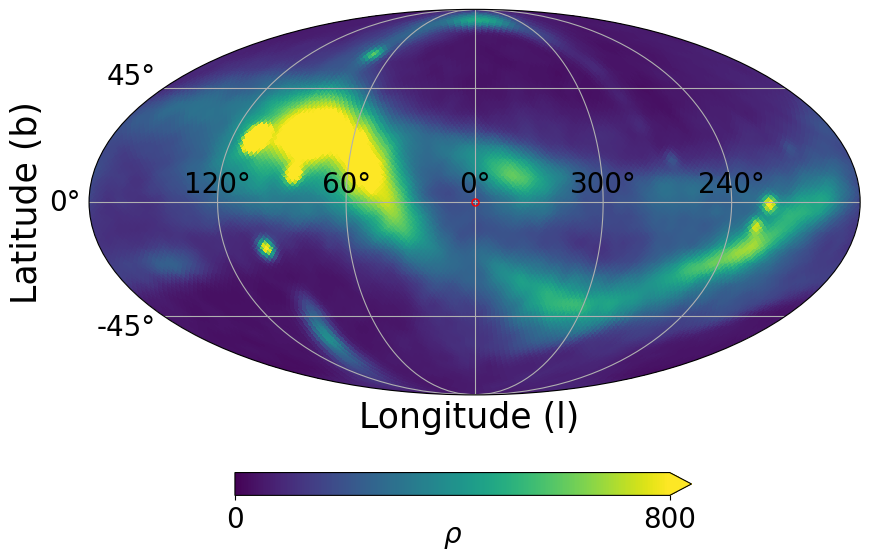

In [61]:
from IPython.display import Image
Image(fig_ananke)

### BHB

In [62]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_bhb = nba.kinematics.Kinematics(anankePos[bhb_mask], anankeVel[bhb_mask])
pos_galactic_bhb = kinematics1_bhb.pos_cartesian_to_galactic()
vel_galactic_bhb = kinematics1_bhb.vel_cartesian_to_galactic()

In [63]:
fig_bhb = f"bhb_mollweide.png"
pl.mollweide_projection(pos_galactic_bhb[0]*180/np.pi, pos_galactic_bhb[1]*180/np.pi, 0, 0, 
                        sim_dir=sim_dir, bmin=0, bmax=1, nside=40, smooth=5, figname=fig_bhb)

* Saving figure in  bhb_mollweide.png


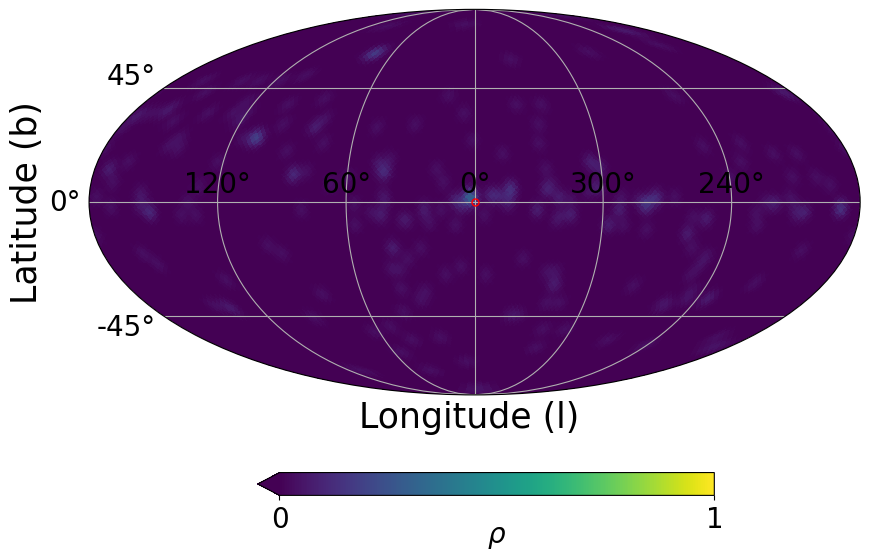

In [64]:
from IPython.display import Image
Image(fig_bhb)

### K Giant

In [65]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_kgiant = nba.kinematics.Kinematics(anankePos[kgiant_mask], anankeVel[kgiant_mask])
pos_galactic_kgiant = kinematics1_kgiant.pos_cartesian_to_galactic()
vel_galactic_kgiant = kinematics1_kgiant.vel_cartesian_to_galactic()

In [66]:
fig_kgiant = f"kgiant_mollweide.png"
pl.mollweide_projection(pos_galactic_bhb[0]*180/np.pi, pos_galactic_bhb[1]*180/np.pi, 0, 0, 
                        sim_dir=sim_dir, bmin=0, bmax=1, nside=40, smooth=5, figname=fig_kgiant)

* Saving figure in  kgiant_mollweide.png


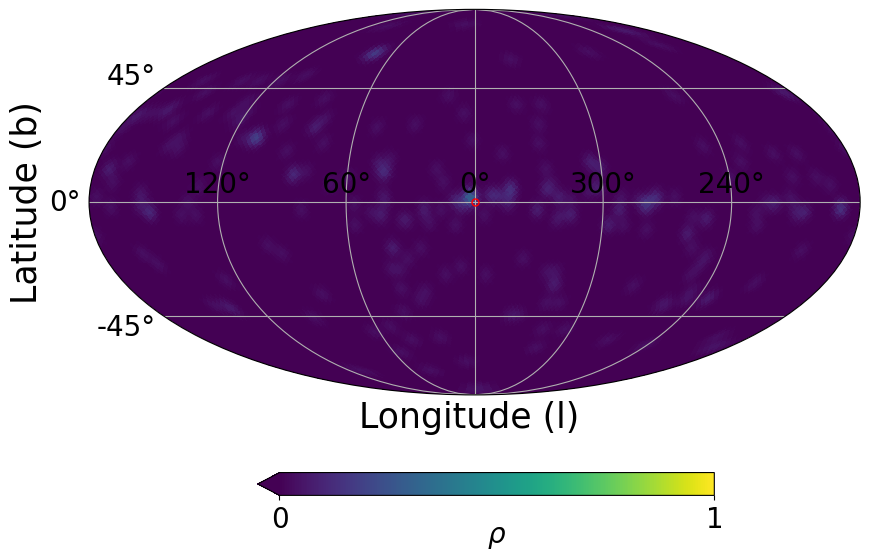

In [67]:
from IPython.display import Image
Image(fig_kgiant)

### MSTO

In [68]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_msto = nba.kinematics.Kinematics(anankePos[msto_mask], anankeVel[msto_mask])
pos_galactic_msto = kinematics1_msto.pos_cartesian_to_galactic()
vel_galactic_msto = kinematics1_msto.vel_cartesian_to_galactic()

In [69]:
fig_msto = f"msto_mollweide.png"
pl.mollweide_projection(pos_galactic_msto[0]*180/np.pi, pos_galactic_msto[1]*180/np.pi, 0, 0, 
                        sim_dir=sim_dir, bmin=0, bmax=200, nside=40, smooth=5, figname=fig_msto)

* Saving figure in  msto_mollweide.png


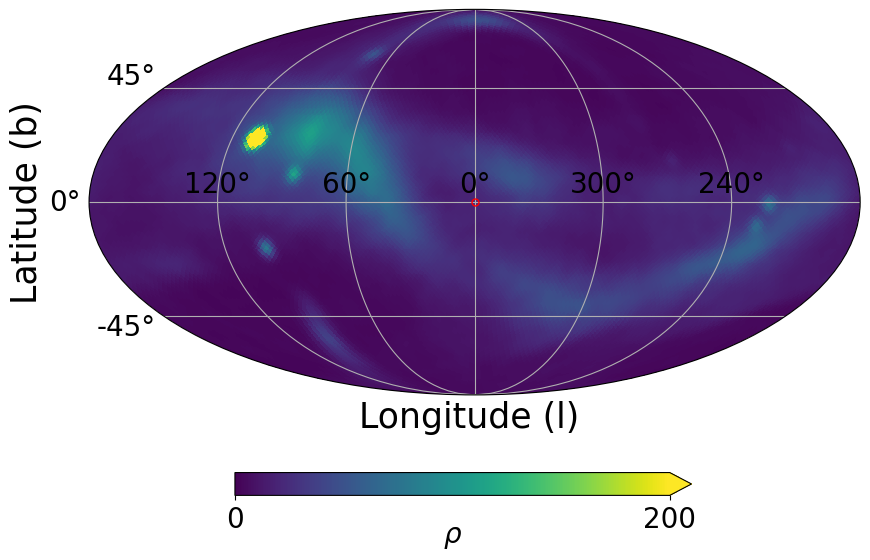

In [70]:
from IPython.display import Image
Image(fig_msto)

### Ananke and Galactic Coords

In [71]:
glat = survey.glat.to_numpy()
glon = survey.glon.to_numpy()

In [72]:
print(glat)
print(min(glat))
print(max(glat))
print(glon)
print(min(glon))
print(max(glon))

[-47.76541  -48.091717 -47.058037 ...  13.28284   13.619347  13.23244 ]
-89.945244
89.96327
[-151.21498 -151.51828 -152.56477 ... -168.27031 -168.04633 -167.97844]
-179.99998
179.99992


In [73]:
glat_rad = np.radians(glat)
glon_rad = np.radians(glon)

# Print the results
print(glat_rad)
print(min(glat_rad))
print(max(glat_rad))
print(glon_rad)
print(min(glon_rad))
print(max(glon_rad))

[-0.8336637  -0.8393588  -0.8213177  ...  0.23182929  0.23770244
  0.23094964]
-1.5698407
1.5701553
[-2.6391993 -2.6444929 -2.6627576 ... -2.9368708 -2.9329617 -2.9317768]
-3.1415923
3.1415913


In [74]:
figname = f"test_mollweide.png"
pl.mollweide_projection(glat_rad, glon_rad, 0, 0, 
                        sim_dir=sim_dir, bmin=0, bmax=1000, nside=40, smooth=5, figname=figname)

* Saving figure in  test_mollweide.png


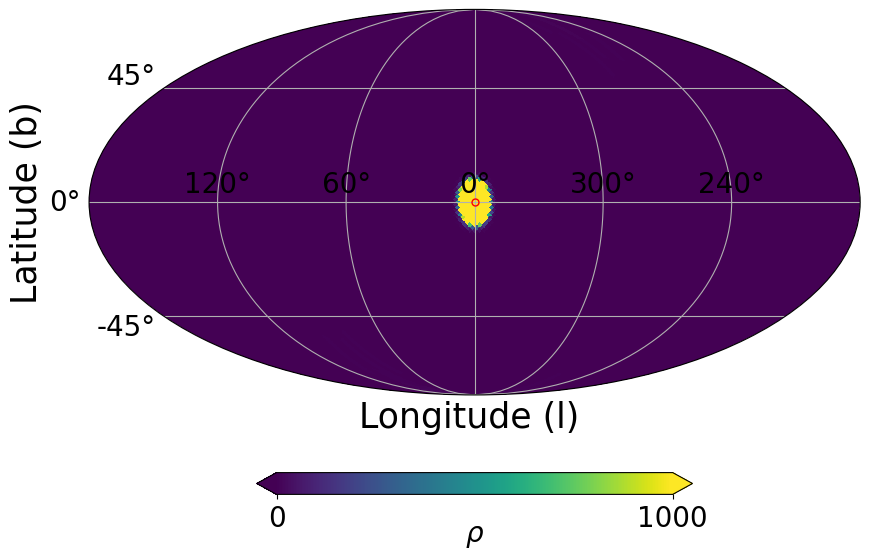

In [75]:
from IPython.display import Image
Image(figname)